In [1]:
%matplotlib inline

import numpy as np
import glob
import math
import time
from scipy import stats
import os
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [2]:
def gaus2d(xy, amplitude=1, mx=0, my=0, sx=1, sy=1, offset=0):
    x, y = xy
    g = offset + amplitude / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
    return g.ravel()

In [3]:
def qckplot(img, xgrid=None, ygrid=None):
    plt.imshow(img, cmap=plt.cm.jet, origin='bottom', extent=(xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()))
    plt.colorbar()

def plotgrid(imgs, titles, rows=2, cols=2, xgrid=None, ygrid=None):
    fig, axs = plt.subplots(rows, cols, figsize=[5*cols, 5*rows])
    for col in range(cols):
        for row in range(rows):
            if row*cols + col >= len(imgs):
                break
            if rows == 1 or cols == 1:
                ax = axs[row+col]
            else:
                ax = axs[row, col]
            hist = imgs[row*cols + col]
            pcm = ax.imshow(hist, cmap=plt.cm.jet, origin='bottom', 
                            extent=(xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()))
            fig.colorbar(pcm, ax=ax)
            ax.set_title(titles[row*cols + col])
    plt.show()

def plot_estimate(img, approx_logl, bgm, hist, dx=None, dy=None, xgrid=None, ygrid=None):
    histnorm = hist / np.sum(hist) / dx / dy
    plotgrid([img, histnorm, np.exp(approx_logl), histnorm - np.exp(approx_logl)],
             ["Input", "Histogram norm.", "Approx. prob.", "Hist norm. - Approx diff"], 1, 4, xgrid=xgrid, ygrid=ygrid)

def estimate_and_plot(img, nclusters=5, gmtype='bgm', maxsamples=300):
    approx_logl, bgm, hist = get_BGM_approx(img, vxg, vyg, maxsamples=maxsamples, nclusters=nclusters, gmtype=gmtype)
    plot_estimate(img, approx_logl, bgm, hist)
    return approx_logl, bgm, hist

In [4]:
# https://xavierbourretsicotte.github.io/gaussian_mixture.html

from scipy.stats import multivariate_normal
import numpy as np
from tqdm import tqdm

class custom_GaussianMixture(object):
    '''Gaussian Mixture Model - vectorized implementation'''
    
    def __init__(self, n_components = 3, max_iter = 100, tol = 0.001, silent=False):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.means_ = None
        self.covariances_ = None
        self.log_likelihoods = None
        self.weights_ = None
        self.silent = silent
    
    def fit(self, X, y = None):
        n,d = X.shape  ## n = datapoints, d = features
        k = self.n_components  ## K number of clusters
        # randomly initialize the starting means
        mu = X[np.random.choice(n,k,replace = False)]
        # initialize a covariance matrix for each gaussian
        Sigma = [np.eye(d)] * k
        # initialize the probability for each gaussian pi
        pi = np.array([1 / k] * k)
        # initialize responsibility matrix: n points for each gaussian
        W = np.zeros((n,k))
        # initialize list of log-likelihoods
        log_likelihoods = []
        # lambda function for gaussian pdf
        P = lambda m ,s: multivariate_normal.pdf(X, mean = m, cov = s, allow_singular=True)
        prf = tqdm
        if self.silent: prf = lambda x: x
        #===============================================================#
#         while len(log_likelihoods) < self.max_iter:
        for i in prf(range(self.max_iter)):
            # E step
            # nominator of responsibilities: j is the j-th gaussian
            for j in range(k):
                W[:, j] = pi[j] * P(mu[j], Sigma[j])

            # log likelihood computation (same as nominator of responsibilities)    
            l = np.sum(np.log(np.sum(W, axis = 1)))
            # store log likelihood in list
            log_likelihoods.append(l)
            # compute W matrix by dividing by denominator (the sum along j) 
            # effectively normalize for each point across clusters
            W = (W.T / W.sum(axis = 1)).T
            # sum of w^i entries along j (used for parameter updates)
            # these are the soft weighted number of datapoints belonging to each gaussian            
            W_s = np.sum(W, axis = 0)

            # M step
            for j in range(k):
                ## Update means
                mu[j] = (1. / W_s[j]) * np.sum(W[:, j] * X.T, axis = 1).T
                ## Update covariances
                Sigma[j] = ((W[:,j] * ((X - mu[j]).T)) @ (X - mu[j])) / W_s[j]
                ## Update probabilities of each gaussian
                pi[j] = W_s[j] / n

            # check for convergence
            if len(log_likelihoods) < 2: continue
            if np.abs(l - log_likelihoods[-2]) < self.tol: break

        self.means_ = mu
        self.covariances_ = Sigma
        self.log_likelihoods = log_likelihoods
        self.weights_ = pi
        return self
    
    def predict_proba(self,x0):
        probs = np.array([ multivariate_normal.pdf(x0, mean = self.means_[j], cov = self.covariances_[j], allow_singular=True) for j in range(self.n_components) ])
        return probs
    
    def predict(self,x0):
        probs = np.array([ multivariate_normal.pdf(x0, mean = self.means_[j], cov = self.covariances_[j], allow_singular=True) for j in range(self.n_components) ])
        return np.argmax(probs, axis = 0)
    
    def score_samples(self, x0):
        return np.sum(np.array([ multivariate_normal.logpdf(x0, mean = self.means_[j], cov = self.covariances_[j], allow_singular=True) * self.weights_[j] \
                                for j in range(self.n_components) ]), axis=0) / self.n_components


In [5]:
from sklearn import mixture

def normalize(img):
    positive = img - np.min(img)
    return positive / np.max(positive)

def get_BGM_approx(lkimg, xgrid, ygrid, maxsamples=2000, nclusters=5, wcp=None, maxiter=100, gmtype='bgm', tolerance=0.001, silent=True, altnorm=False):
    LENX, LENY = lkimg.shape
    LKMIN, LKMAX = (np.min(lkimg), np.max(lkimg))
    if LKMIN == LKMAX:
        lkimghist = np.ones((LENX, LENY))
    elif altnorm:
        lkimghist = np.exp(lkimg - LKMAX) * maxsamples
    else:
#         lkimgnorm = (lkimg - LKMIN) / (LKMAX - LKMIN) * maxsamples
        lkimghist = normalize(lkimg) * maxsamples

    # sample from the normalized image
    if not silent:
        print("Creating samples from normalized likelihood...")
    samples = []
    for i in range(LENX):
        for j in range(LENY):
            for n in range(int(lkimghist[i, j])):
                samples.append([xgrid[i,j], ygrid[i,j]])
    samples = np.array(samples)
    
    if not silent:
        print(f"Estimating BGM with {nclusters} clusters...")
    if gmtype == 'bgm':
        bgm = mixture.BayesianGaussianMixture(n_components=nclusters, covariance_type='full',
                                         weight_concentration_prior=wcp, max_iter=maxiter, tol=tolerance).fit(samples)
    elif gmtype == 'custom':
        bgm = custom_GaussianMixture(n_components=nclusters, max_iter=maxiter, tol=tolerance, silent=silent).fit(samples)
    else:
        bgm = mixture.GaussianMixture(n_components=nclusters, covariance_type='full',
                                         max_iter=maxiter, tol=tolerance).fit(samples)
    if not silent:
        print(f"BGM WEIGHTS: {bgm.weights_}\nBGM MEANS: {bgm.means_}\nBGM COVARS: {bgm.covariances_}")
    points = np.array([xgrid.ravel(), ygrid.ravel()]).T
    scores = bgm.score_samples(points)
    scores = scores.reshape(lkimg.shape)

    return scores, bgm, lkimghist

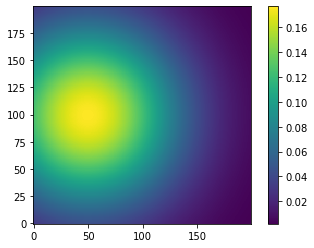

In [9]:
NPOINTS=200

x = np.linspace(-5, 5, NPOINTS)
y = np.linspace(-5, 5, NPOINTS)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
# def gaus2d(xy, amplitude=1, mx=0, my=0, sx=1, sy=1, offset=0):
z = gaus2d((x, y), 10, -2.5, 0, 3, 3, 0)
g2do = z.reshape(NPOINTS, NPOINTS)

dxyg2 = (x.max() - x.min())/NPOINTS

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(g2do, origin='bottom')
plt.colorbar()

In [7]:
g2dlikefito, g2dbgmo, g2dhisto = get_BGM_approx(g2do, x, y, maxsamples=300, maxiter=100, nclusters=1, silent=False, gmtype='bgm')

Creating samples from normalized likelihood...
Estimating BGM with 1 clusters...
BGM WEIGHTS: [1.]
BGM MEANS: [[-1.55584712e+00  7.64745243e-13]]
BGM COVARS: [[[4.66389698e+00 1.35646005e-16]
  [1.35646005e-16 5.64923433e+00]]]


In [64]:
g2dlikefito3, g2dbgmo3, g2dhisto3 = get_BGM_approx(g2do, x, y, maxsamples=300, maxiter=100, nclusters=3, silent=False, gmtype='bgm')

Creating samples from normalized likelihood...
Estimating BGM with 3 clusters...
BGM WEIGHTS: [0.24754034 0.22951237 0.5229473 ]
BGM MEANS: [[-3.21731624 -1.73224591]
 [-3.04920527  2.04701809]
 [-0.11397263 -0.0784311 ]]
BGM COVARS: [[[ 1.18832369 -0.13850993]
  [-0.13850993  2.60358921]]

 [[ 1.3835574   0.08941535]
  [ 0.08941535  2.22269673]]

 [[ 3.38431151  0.11868943]
  [ 0.11868943  5.32917321]]]


In [15]:
g2dlikefitoc, g2dbgmoc, g2dhistoc = get_BGM_approx(g2do, x, y, maxsamples=300, maxiter=300, tolerance=0.00001, nclusters=1, silent=False, gmtype='custom')

Creating samples from normalized likelihood...


  0%|          | 0/300 [00:00<?, ?it/s]

Estimating BGM with 1 clusters...


  1%|          | 2/300 [00:01<03:14,  1.53it/s]

BGM WEIGHTS: [1.]
BGM MEANS: [[-1.55584712e+00 -1.47558285e-16]]
BGM COVARS: [array([[4.66389696e+00, 1.68885068e-16],
       [1.68885068e-16, 5.64923453e+00]])]


In [16]:
g2dlikefito3c, g2dbgmo3c, g2dhisto3c = get_BGM_approx(g2do, x, y, maxsamples=300, maxiter=300, tolerance=0.00001, nclusters=3, silent=False, gmtype='custom')

Creating samples from normalized likelihood...


  0%|          | 0/300 [00:00<?, ?it/s]

Estimating BGM with 3 clusters...


100%|██████████| 300/300 [06:30<00:00,  1.30s/it]

BGM WEIGHTS: [0.20841242 0.50438394 0.28720365]
BGM MEANS: [[-1.00145352  2.67356067]
 [-0.62230703 -1.0527835 ]
 [-3.5976218  -0.09121109]]
BGM COVARS: [array([[ 3.83033517, -0.10746548],
       [-0.10746548,  1.50156033]]), array([[3.88370693, 0.31989801],
       [0.31989801, 3.64125804]]), array([[ 0.71655025, -0.01961828],
       [-0.01961828,  5.04365843]])]


Approximation with 1 clusters, Bayesian GMM:

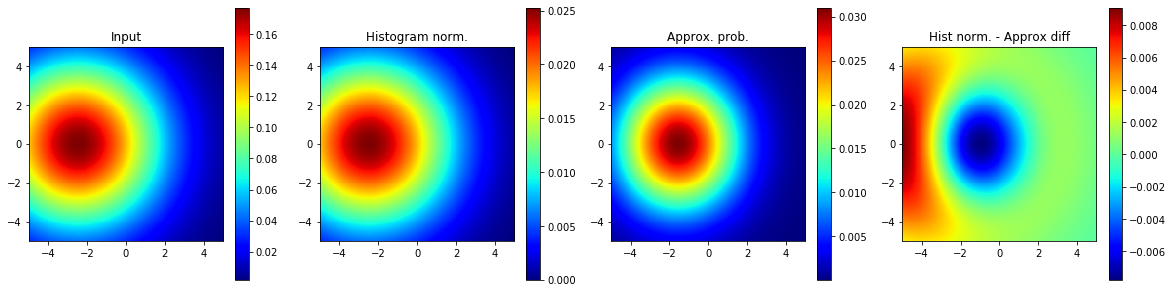

In [10]:
plot_estimate(g2do, g2dlikefito, g2dbgmo, g2dhisto, dx=dxyg2, dy=dxyg2, xgrid=x, ygrid=y)

Approximation with 3 clusters, Bayesian GMM:

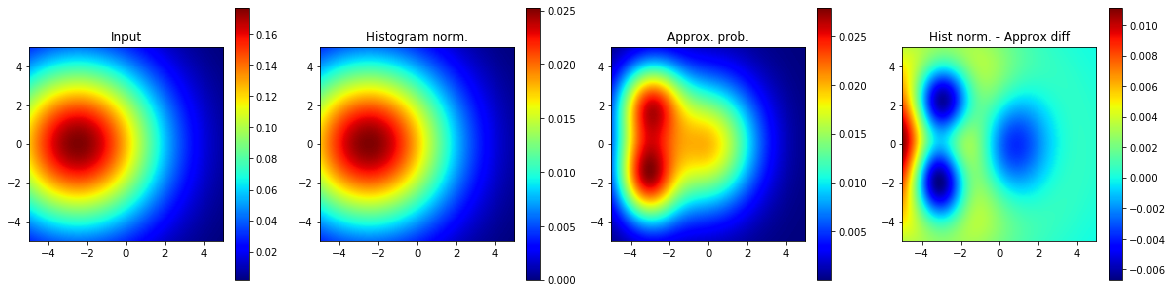

In [66]:
plot_estimate(g2do, g2dlikefito3, g2dbgmo3, g2dhisto3, dx=dxyg2, dy=dxyg2, xgrid=x, ygrid=y)

Approximation with 1 clusters, custom GMM:

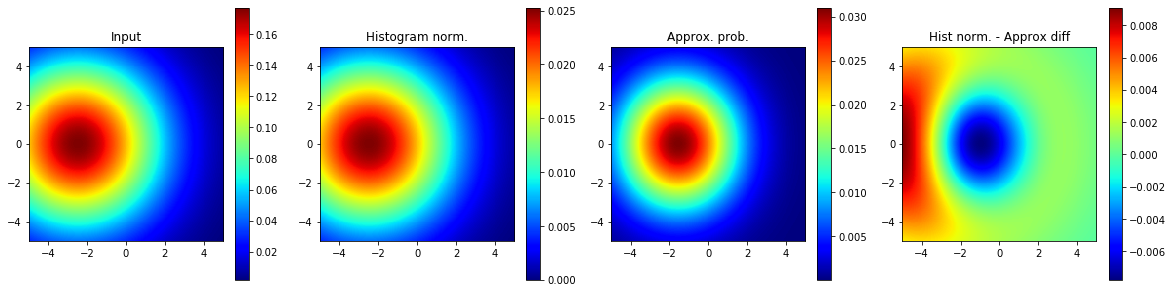

In [20]:
plot_estimate(g2do, g2dlikefitoc, g2dbgmoc, g2dhistoc, dx=dxyg2, dy=dxyg2, xgrid=x, ygrid=y)

Approximation with 3 clusters, custom GMM:

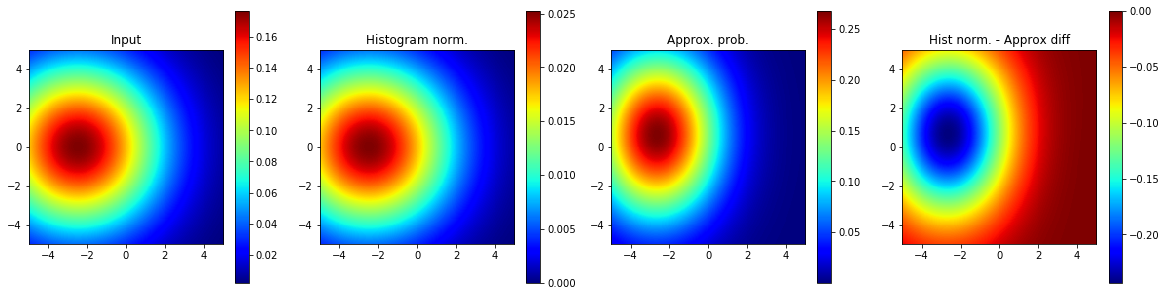

In [19]:
plot_estimate(g2do, g2dlikefito3c, g2dbgmo3c, g2dhisto3c, dx=dxyg2, dy=dxyg2, xgrid=x, ygrid=y)